In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator
from estimators.particleFilterEstimator import ParticleFilterEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *
from utils.save import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

In [3]:
# Facultatively load a workspace
workspace_path=None #'workspaces/20210723-134410' # None or workspace_path (workspaces/...)

if workspace_path is not None:
    load_workspace(workspace_path, globals())
    print('Wokspace loaded.')
else:
    print('No workspace loaded.')

No workspace loaded.


In [4]:
# Set parameters
estimatorType='kalman' # kalman, particle or rnn

seeAction=True
seeMeasurement=False
seeEstimate=False
seeTime=True

T=12+1

threshold=4
windowSize=T

if estimatorType=='rnn':
    cost=500
elif estimatorType=='particle':
    cost=100 # 0 < cost= < 10
elif estimatorType=='kalman':
    cost=100 # 0 < cout=50 < 1000

In [5]:
if estimatorType=='rnn' and 'model' not in dir(): # if a RNN model has not been loaded
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=500
    T_trainRNN=T
    generatorType='particle'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=1-threshold/windowSize)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    n_epochs_RNN=20
    history=model.fit(x=measurements_corrupted_trainRNN,y=objectives_trainRNN,batch_size=1,epochs=n_epochs_RNN,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
    
    idx_sample=0
    estimates_trainRNN=model.predict(measurements_corrupted_trainRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

Done


In [6]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType == 'particle':
    estimator=ParticleFilterEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()

Kalman estimator
  observationsDimensions: [(12,), (1,)]
  seeAction= True
  seeMeasurement= False
  seeEstimate= False
  seeTime= True
  seeCovariance= False


In [7]:
# contruct rewarder
rewarder=ThresholdRewarder(threshold=threshold, cost=cost, windowSize=windowSize)
rewarder.summarize()

Threshold rewarder
  window size: 13
  threshold: 4
  cost: 100
  number of measures in the window: 0


In [8]:
# generate sequences for training and validating the agent
numberSamples_train=500
T_train=T

numberSamples_valid=numberSamples_train
T_valid=T_train

if workspace_path is None: # data have not been loaded
    (objectives_train,measurements_train)=estimator.generateSequence(T_train,numberSamples=numberSamples_train)
    (objectives_valid,measurements_valid)=estimator.generateSequence(T_valid,numberSamples=numberSamples_valid)
    print('New data generated')
else:
    print('No new data generated')

#print('----- TO REMOVE -----')
#objectives_valid = objectives_train
#measurements_valid = measurements_train

print('shape training objectives:',np.shape(objectives_train))
print('shape training measurements:',np.shape(measurements_train))
print('shape validating objectives:',np.shape(objectives_valid))
print('shape validating measurements:',np.shape(measurements_valid))

/Users/antoine/anaconda3/lib/python3.6/site-packages/pykalman-0.9.5-py3.6.egg/pykalman/standard.py:1108: RuntimeWarning: covariance is not positive-semidefinite.
  transition_covariance.newbyteorder('=')


New data generated
shape training objectives: (500, 13, 1)
shape training measurements: (500, 13, 1)
shape validating objectives: (500, 13, 1)
shape validating measurements: (500, 13, 1)


In [9]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)
print('Agent constructed')

Environment parameters
  inputDimensions= [(12,), (1,)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 1
  n_dim_meas= 1
  numberSamples_train 500
  numberSamples_valid 500
Kalman estimator
  observationsDimensions: [(12,), (1,)]
  seeAction= True
  seeMeasurement= False
  seeEstimate= False
  seeTime= True
  seeCovariance= False
Threshold rewarder
  window size: 13
  threshold: 4
  cost: 100
  number of measures in the window: 0
Instructions for updating:
Colocations handled automatically by placer.
Agent constructed


In [10]:
# Train agent
n_epochs_agent=50

agent.resumeTrainingMode() # not required
agent.run(n_epochs=n_epochs_agent, epoch_length=numberSamples_train*T_train)
cumulatedRewards_valid=agent._controllers[-1].rewards # interleavedValidEpochController is the last controller.
print('Agent Trained')

Instructions for updating:
Use tf.cast instead.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -7.9079247326878574 (average over 500 episode(s))
Training epoch 1/50.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -15.163470040234298 (average over 500 episode(s))
Training epoch 2/50.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -5.534853300028257 (average over 500 episode(s))
Training epoch 3/50.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -15.16347004023424 (average over 500 episode(s))
Training epoch 4/50.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -15.163470040234266 (average over 500 episode(s))
Training epoch 5/50.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -6.719710735806358 (average over 500 episode(s))
Training epoch 6/50.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -5.534853300028242

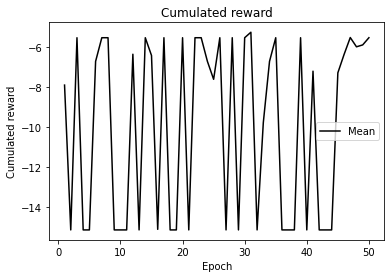

/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting

meanReward_valid:  -5.534853300028262


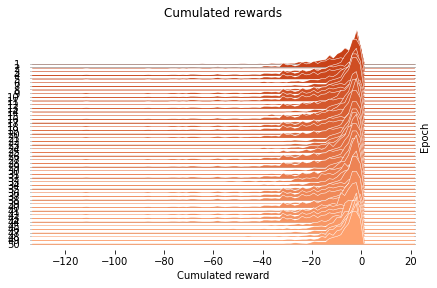

In [11]:
# plot validation
#boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

meanReward_valid=np.mean(cumulatedRewards_valid[-1])
print('meanReward_valid: ',meanReward_valid)

In [12]:
# generate test data
numberSamples_test=numberSamples_train
T_test=T
    
if workspace_path is None: # data have not been loaded
    (objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)
    print('New data generated')
else:
    print('No new data generated')

#print('----- TO REMOVE -----')
#objectives_test = objectives_train
#measurements_test = measurements_train


# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

/Users/antoine/anaconda3/lib/python3.6/site-packages/pykalman-0.9.5-py3.6.egg/pykalman/standard.py:1108: RuntimeWarning: covariance is not positive-semidefinite.
  transition_covariance.newbyteorder('=')


New data generated
Test results computed


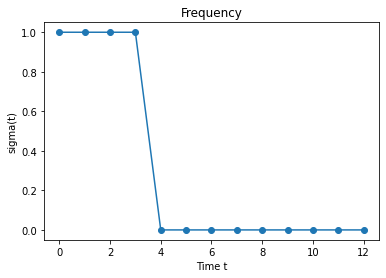

T: 13


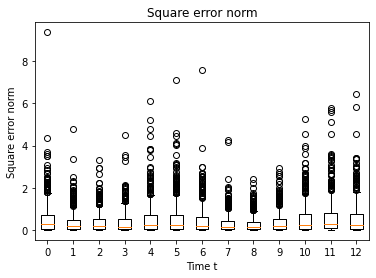

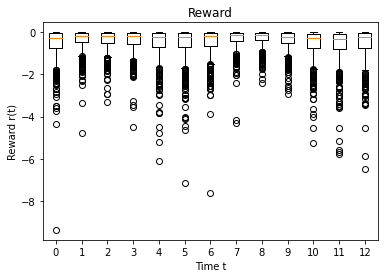

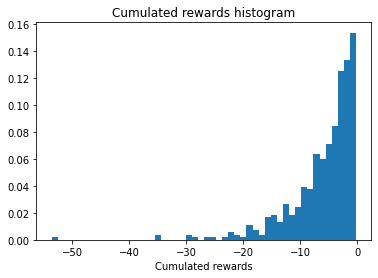

meanReward_test:  -0.45970672382141214
sumSigmas_test [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 

In [13]:
# plot test
idx_sample=0
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
#plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
#plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)

meanReward_test=np.mean(rewards_test)
print('meanReward_test: ',meanReward_test)

sumSigmas_test=np.sum(sigmas_test,axis=1)
print('sumSigmas_test',sumSigmas_test)

In [14]:
# regular run on test data (default case without agent)
numberMeasurements=int(np.ceil(threshold/windowSize*T))

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_valid,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

Done.


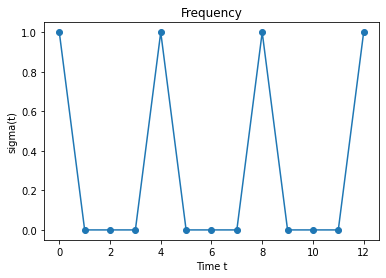

T: 13


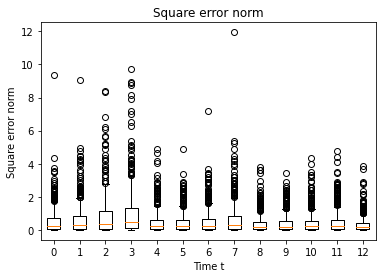

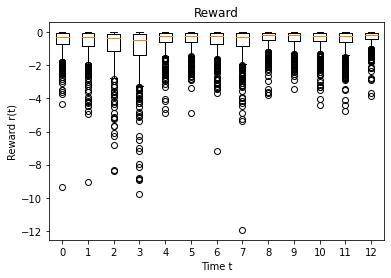

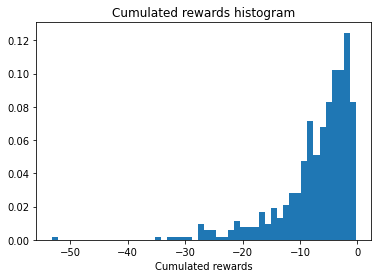

meanReward_regular:  -0.5533783574230806


In [15]:
# plot test regular
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
#plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
#plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)
meanReward_regular=np.mean(rewards_regular)
print('meanReward_regular: ',meanReward_regular)

In [16]:
toSave=["estimatorType","seeAction","seeMeasurement","seeEstimate","seeTime","T","threshold","windowSize","cost"]
if estimatorType=='rnn':
    toSave.extend(["numberSamples_trainRNN","T_trainRNN","generatorType","objectives_trainRNN","measurements_trainRNN","n_epochs_RNN","model","history","estimates_trainRNN"])
toSave.extend(["estimator","rewarder"])
toSave.extend(["numberSamples_train","T_train","numberSamples_valid","T_valid","objectives_train","measurements_train","objectives_valid","measurements_valid"])
toSave.extend(["agent","n_epochs_agent"])
toSave.extend(["cumulatedRewards_valid","meanReward_valid"])
toSave.extend(["numberSamples_test","T_test","objectives_test","measurements_test","sigmas_test","rewards_test","estimates_test"])
toSave.extend(["meanReward_test","sumSigmas_test"])
toSave.extend(["numberMeasurements","sigmas_regular","rewards_regular","estimates_regular","meanReward_regular"])
save_workspace('workspaces/',toSave,globals())

estimatorType
seeAction
seeMeasurement
seeEstimate
seeTime
T
threshold
windowSize
cost
estimator
rewarder
numberSamples_train
T_train
numberSamples_valid
T_valid
objectives_train
measurements_train
objectives_valid
measurements_valid
cumulatedRewards_valid
meanReward_valid
numberSamples_test
T_test
objectives_test
measurements_test
sigmas_test
rewards_test
estimates_test
meanReward_test
sumSigmas_test
numberMeasurements
sigmas_regular
rewards_regular
estimates_regular
meanReward_regular


In [17]:
import os
os.system( "say Au travail faignant." )

0